In [ ]:
# --- install deps -----------------------------------------------------------
!pip install -U yt-dlp opencv-python-headless torch numpy

# --- download 144p source ---------------------------------------------------
url = "https://www.youtube.com/watch?v=rET3lp6kk2E"
!yt-dlp -f 160 -o "video_144p.mp4" {url}




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

ValueError: need at least one array to stack

[youtube] Extracting URL: https://www.youtube.com/watch?v=rET3lp6kk2E
[youtube] rET3lp6kk2E: Downloading webpage
[youtube] rET3lp6kk2E: Downloading tv client config
[youtube] rET3lp6kk2E: Downloading player 6450230e-main
[youtube] rET3lp6kk2E: Downloading tv player API JSON
[youtube] rET3lp6kk2E: Downloading ios player API JSON
[youtube] rET3lp6kk2E: Downloading m3u8 information
[info] rET3lp6kk2E: Downloading 1 format(s): 160
[download] video_144p.mp4 has already been downloaded
[download] 100% of   15.29MiB
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcode

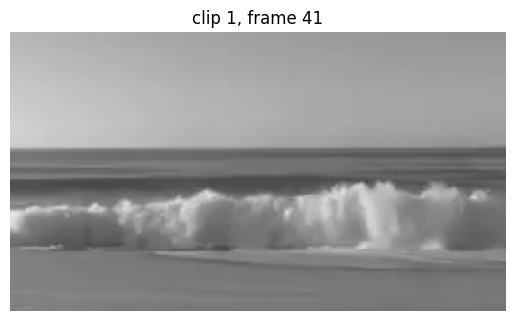

  adding: tensor_dataset_bigShip.pt (deflated 74%)


In [ ]:
# --- install deps -----------------------------------------------------------
!pip install -U yt-dlp opencv-python-headless torch numpy

# --- download 144p source ---------------------------------------------------
url = "https://www.youtube.com/watch?v=rET3lp6kk2E"
!yt-dlp -f 160 -o "video_144p.mp4" {url}

# --- make grayscale 256×144, 8 fps, overlay *3× taller* ship -----------------
"""
critical: ship height = 54 px  (3 × 18 px → one‑quarter of 144 px frame);
overlay moves only between 1800‑1860 s (30‑31 min);
x(t)  = (t‑1800)*(W+ow)/60 – ow
"""
!ffmpeg -i video_144p.mp4 -i ship.png -filter_complex \
"[1:v]crop=1675:808:186:346,scale=-1:54[ship]; \
 [0:v]scale=256:144,format=gray,fps=8[base]; \
 [base][ship]overlay=x='if(between(t,1800,1860),(t-1800)*(main_w+overlay_w)/60-overlay_w,NAN)':\
y='(main_h-overlay_h)/2',format=gray" \
-c:v libx264 -crf 23 -preset veryfast video_144p_8fps_shipBIG.mp4 -y

# --- split to 10‑second clips + stack to tensor -----------------------------
import cv2, torch, numpy as np, os

VIDEO_PATH        = 'video_144p_8fps_shipBIG.mp4'
FPS, CLIP_SECONDS = 8, 10
FRAMES_PER_CLIP   = FPS * CLIP_SECONDS           # 80
clips, clip_buf   = [], []

cap = cv2.VideoCapture(VIDEO_PATH)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clip_buf.append(gray)
    if len(clip_buf) == FRAMES_PER_CLIP:
        clips.append(np.stack(clip_buf, axis=2).astype(np.uint8))
        clip_buf.clear()
cap.release()
if clip_buf:
    print(f"⚠️ trailing {len(clip_buf)} frames discarded")

dataset_np    = np.stack(clips, axis=0)          # (N,H,W,T)
dataset_torch = torch.from_numpy(dataset_np)
torch.save(dataset_torch, 'tensor_dataset_bigShip.pt')
print("saved tensor_dataset_bigShip.pt →", dataset_torch.shape)

# --- quick sanity check ------------------------------------------------------
import matplotlib.pyplot as plt
plt.imshow(dataset_np[0, :, :, 40], cmap='gray', vmin=0, vmax=255)
plt.title('clip 1, frame 41')
plt.axis('off')
plt.show()

# --- zip for download --------------------------------------------------------
!zip -9 tensor_dataset_bigShip.zip tensor_dataset_bigShip.pt
